In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import time 
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')

In [2]:
def generate_points(x_range=(-1, 1), step=0.01):
    """
    Generate a sequence of points within the given range and step.

    Parameters:
    x_range (tuple): Range of x values (min, max).
    step (float): Step size for generating points.

    Returns:
    numpy.ndarray: Array of x values.
    """
    return np.arange(x_range[0], x_range[1], step)

In [3]:
def generate_polynomial_values(x, degree=3, coefficients=None):
    """
    Generate y values based on a polynomial function of a given degree.

    Parameters:
    x (numpy.ndarray): Array of x values.
    degree (int): Degree of the polynomial.
    coefficients (list or None): Coefficients of the polynomial. If None, random coefficients are generated.

    Returns:
    numpy.ndarray: Array of y values.
    """
    if coefficients is None:
        coefficients = np.random.randn(degree + 1)
    print("Coefficients are:", coefficients)
    return np.polyval(coefficients, x), coefficients

In [4]:
def sample_train_set(x, y, train_size=30):
    """
    Sample a training set of a specified size.

    Parameters:
    x (numpy.ndarray): Array of x values.
    y (numpy.ndarray): Array of y values.
    train_size (int): Number of samples for the training set.

    Returns:
    tuple: Arrays of x_train and y_train.
    """
    train_indices = np.random.choice(len(x), train_size, replace=False)
    return x[train_indices], y[train_indices]

In [5]:
def create_bootstraps_with_indices(x_train, y_train, n_bootstraps=3, degree=1):
    """
    Create bootstrap samples and train polynomial models on each.
    Also, return the indices used for each bootstrap sample.

    Parameters:
    x_train (numpy.ndarray): Array of x values in the training set.
    y_train (numpy.ndarray): Array of y values in the training set.
    n_bootstraps (int): Number of bootstrap samples to create.
    degree (int): Degree of the polynomial model to fit.

    Returns:
    list: List of trained polynomial models.
    list: List of indices used for each bootstrap sample.
    """
    models = []
    indices_list = []
    subset_size = len(x_train) // n_bootstraps  # Calculate size of each subset

    for i in range(n_bootstraps):
        # Define start and end indices for the current subset
        start_idx = i * subset_size
        end_idx = (i + 1) * subset_size if i != n_bootstraps - 1 else len(x_train)

        # Create the subset and store indices
        x_subset = x_train[start_idx:end_idx]
        y_subset = y_train[start_idx:end_idx]
        indices_list.append((start_idx, end_idx))

        # Create a polynomial regression model pipeline
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        # Fit the model to the subset
        model.fit(x_subset.reshape(-1, 1), y_subset)

        # Append the trained model to the list
        models.append(model)

    return models, indices_list


In [6]:
def sample_val_set(x, y, val_size=10):
    """
    Sample a validation set of a specified size.

    Parameters:
    x (numpy.ndarray): Array of x values.
    y (numpy.ndarray): Array of y values.
    val_size (int): Number of samples for the validation set.

    Returns:
    tuple: Arrays of x_val and y_val.
    """
    val_indices = np.random.choice(len(x), val_size, replace=False)
    return x[val_indices], y[val_indices]

In [7]:
# Define the base models (these are the models trained earlier)
class BaseModelEnsemble:
    def __init__(self, models):
        self.models = models

    def predict(self, x):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(x.reshape(-1, 1)).reshape(-1))
        return np.array(predictions).T  # Shape (n_samples, n_models)

In [8]:
class WeightedEnsembleNetwork(nn.Module):
    def __init__(self, input_dim=1, n_models=3, n_layers=1, n_neurons=10):
        super(WeightedEnsembleNetwork, self).__init__()
        layers = []
        in_features = input_dim

        # Build hidden layers based on n_layers and n_neurons
        for _ in range(n_layers):
            layers.append(nn.Linear(in_features, n_neurons))
            layers.append(nn.ReLU())
            in_features = n_neurons

        # Output layer mapping to n_models (number of base models)
        layers.append(nn.Linear(in_features, n_models))

        self.network = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)  # Ensure outputs sum to 1

    def forward(self, x):
        x = self.network(x)
        phi = self.softmax(x)
        return phi

def train_weighted_ensemble_network(
    x_val, f_val, y_val, n_layers=1, n_neurons=10, learning_rate=0.01,
    delta_loss_threshold=1e-6, max_epochs=10000, patience=10
):
    """
    Train the weighted ensemble network with early stopping based on loss change.

    Parameters:
    - x_val (numpy.ndarray): Validation inputs of shape [batch_size, ]
    - f_val (numpy.ndarray): Base model predictions on validation data [batch_size, n_models]
    - y_val (numpy.ndarray): True outputs for validation data [batch_size, ]
    - n_layers (int): Number of hidden layers
    - n_neurons (int): Number of neurons per hidden layer
    - learning_rate (float): Learning rate for optimizer
    - delta_loss_threshold (float): Threshold for minimal change in loss to continue training
    - max_epochs (int): Maximum number of epochs to train
    - patience (int): Number of consecutive epochs with minimal loss change to tolerate before stopping

    Returns:
    - ensemble_net (nn.Module): Trained weighted ensemble network
    - opt_info (dict): Optimization information
    """
    input_dim = 1  # Since x_val has only one feature
    n_models = f_val.shape[1]  # Number of base models

    ensemble_net = WeightedEnsembleNetwork(
        input_dim=input_dim, n_models=n_models, n_layers=n_layers, n_neurons=n_neurons
    )
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ensemble_net.parameters(), lr=learning_rate)

    # Reshape x_val to have shape [batch_size, input_dim]
    x_val_tensor = torch.tensor(x_val.reshape(-1, input_dim), dtype=torch.float32)
    f_val_tensor = torch.tensor(f_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

    prev_loss = None
    epoch = 0
    no_improve_epochs = 0

    start_time = time.time()
    total_forward_time = 0.0
    total_backward_time = 0.0

    losses = []

    while epoch < max_epochs:
        epoch += 1

        # Time forward pass
        t0 = time.time()
        # Predict the weights (phis)
        phis = ensemble_net(x_val_tensor)

        # Compute the weighted sum of the base model predictions
        y_pred = torch.sum(phis * f_val_tensor, dim=1).reshape(-1, 1)
        forward_time = time.time() - t0
        total_forward_time += forward_time

        # Compute the loss
        loss = criterion(y_pred, y_val_tensor)
        losses.append(loss.item())

        # Check for early stopping based on change in loss
        if prev_loss is not None:
            loss_change = abs(prev_loss - loss.item())
            if loss_change < delta_loss_threshold:
                no_improve_epochs += 1
            else:
                no_improve_epochs = 0
        prev_loss = loss.item()

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch} due to minimal loss change")
            break

        # Backpropagation and optimization
        t0 = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time = time.time() - t0
        total_backward_time += backward_time

    total_time = time.time() - start_time

    opt_info = {
        'total_time': total_time,
        'num_iterations': epoch,
        'avg_forward_time': total_forward_time / epoch,
        'avg_backward_time': total_backward_time / epoch,
        'losses': losses,
    }

    return ensemble_net, opt_info


def predict_with_weighted_ensemble(ensemble_net, f_test, x_test):
    input_dim = 1  # Since x_test has only one feature
    x_test_tensor = torch.tensor(x_test.reshape(-1, input_dim), dtype=torch.float32)
    f_test_tensor = torch.tensor(f_test, dtype=torch.float32)

    # Predict the weights (phis) using the trained network
    phis = ensemble_net(x_test_tensor)

    # Compute the final prediction as the weighted sum
    y_test_pred = torch.sum(phis * f_test_tensor, dim=1).detach().numpy()

    return y_test_pred


In [9]:
class DirectEnsembleNetwork(nn.Module):
    def __init__(self, n_models=3, n_layers=1, n_neurons=10, output_dim=1):
        super(DirectEnsembleNetwork, self).__init__()
        layers = []
        in_features = n_models

        # Build hidden layers based on n_layers and n_neurons
        for _ in range(n_layers):
            layers.append(nn.Linear(in_features, n_neurons))
            layers.append(nn.ReLU())
            in_features = n_neurons

        # Output layer mapping to the desired output dimension
        layers.append(nn.Linear(in_features, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = self.network(x)
        return y_pred

def train_direct_ensemble_network(
    f_val, y_val, n_layers=1, n_neurons=10, learning_rate=0.01,
    delta_loss_threshold=1e-6, max_epochs=10000, patience=10
):
    """
    Train the direct ensemble network with early stopping based on loss change.

    Parameters:
    - f_val (numpy.ndarray): Base model predictions on validation data [batch_size, n_models]
    - y_val (numpy.ndarray): True outputs for validation data [batch_size, ]
    - n_layers (int): Number of hidden layers
    - n_neurons (int): Number of neurons per hidden layer
    - learning_rate (float): Learning rate for optimizer
    - delta_loss_threshold (float): Threshold for minimal change in loss to continue training
    - max_epochs (int): Maximum number of epochs to train
    - patience (int): Number of consecutive epochs with minimal loss change to tolerate before stopping

    Returns:
    - ensemble_net (nn.Module): Trained direct ensemble network
    - opt_info (dict): Optimization information
    """
    n_models = f_val.shape[1]  # Number of base models

    ensemble_net = DirectEnsembleNetwork(
        n_models=n_models, n_layers=n_layers, n_neurons=n_neurons
    )
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ensemble_net.parameters(), lr=learning_rate)

    f_val_tensor = torch.tensor(f_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

    prev_loss = None
    epoch = 0
    no_improve_epochs = 0

    start_time = time.time()
    total_forward_time = 0.0
    total_backward_time = 0.0

    losses = []

    while epoch < max_epochs:
        epoch += 1

        # Time forward pass
        t0 = time.time()
        # Compute the network's prediction
        y_pred = ensemble_net(f_val_tensor)
        forward_time = time.time() - t0
        total_forward_time += forward_time

        # Compute the loss
        loss = criterion(y_pred, y_val_tensor)
        losses.append(loss.item())

        # Check for early stopping based on change in loss
        if prev_loss is not None:
            loss_change = abs(prev_loss - loss.item())
            if loss_change < delta_loss_threshold:
                no_improve_epochs += 1
            else:
                no_improve_epochs = 0
        prev_loss = loss.item()

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch} due to minimal loss change")
            break

        # Backpropagation and optimization
        t0 = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time = time.time() - t0
        total_backward_time += backward_time

    total_time = time.time() - start_time

    opt_info = {
        'total_time': total_time,
        'num_iterations': epoch,
        'avg_forward_time': total_forward_time / epoch,
        'avg_backward_time': total_backward_time / epoch,
        'losses': losses,
    }

    return ensemble_net, opt_info

def predict_with_direct_ensemble(ensemble_net, f_test):
    f_test_tensor = torch.tensor(f_test, dtype=torch.float32)

    # Compute the final prediction
    y_test_pred = ensemble_net(f_test_tensor).detach().numpy().reshape(-1)

    return y_test_pred

In [25]:
class FixedWeightEnsembleNetwork(nn.Module):
    def __init__(self, n_models=3):
        super(FixedWeightEnsembleNetwork, self).__init__()
        # Initialize weights for each base model's predictions
        self.weights = nn.Parameter(torch.randn(n_models))  # Learnable weights

    def forward(self, f_pred):
        """
        f_pred: Tensor of shape [batch_size, num_models]
            - The predictions from the base models.
        """
        # Apply softmax to ensure weights sum to 1
        w_norm = torch.nn.functional.softmax(self.weights, dim=0)

        # Compute the weighted sum of the base model predictions
        y_pred = torch.sum(w_norm * f_pred, dim=1)

        return y_pred, w_norm

import time

def train_fixed_weight_ensemble(
    f_val, y_val, learning_rate=0.01,
    delta_loss_threshold=1e-6, max_epochs=10000, patience=10
):
    """
    Train the fixed weight ensemble network with early stopping based on loss change.

    Parameters:
    - f_val (numpy.ndarray): Base model predictions on validation data [batch_size, n_models]
    - y_val (numpy.ndarray): True outputs for validation data [batch_size, ]
    - learning_rate (float): Learning rate for optimizer
    - delta_loss_threshold (float): Threshold for minimal change in loss to continue training
    - max_epochs (int): Maximum number of epochs to train
    - patience (int): Number of consecutive epochs with minimal loss change to tolerate before stopping

    Returns:
    - ensemble_net (nn.Module): Trained fixed weight ensemble network
    - opt_info (dict): Optimization information
    """
    n_models = f_val.shape[1]  # Number of base models

    # Initialize the model
    ensemble_net = FixedWeightEnsembleNetwork(n_models=n_models)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ensemble_net.parameters(), lr=learning_rate)

    # Convert validation data to tensors
    f_val_tensor = torch.tensor(f_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1)

    prev_loss = None
    epoch = 0
    no_improve_epochs = 0

    start_time = time.time()
    total_forward_time = 0.0
    total_backward_time = 0.0

    losses = []

    while epoch < max_epochs:
        epoch += 1

        # Time forward pass
        t0 = time.time()
        y_pred, _ = ensemble_net(f_val_tensor)
        forward_time = time.time() - t0
        total_forward_time += forward_time

        # Compute the loss
        loss = criterion(y_pred, y_val_tensor)
        losses.append(loss.item())

        # Check for early stopping based on change in loss
        if prev_loss is not None:
            loss_change = abs(prev_loss - loss.item())
            if loss_change < delta_loss_threshold:
                no_improve_epochs += 1
            else:
                no_improve_epochs = 0
        prev_loss = loss.item()

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch} due to minimal loss change")
            break

        # Backpropagation and optimization
        t0 = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time = time.time() - t0
        total_backward_time += backward_time

    total_time = time.time() - start_time

    opt_info = {
        'total_time': total_time,
        'num_iterations': epoch,
        'avg_forward_time': total_forward_time / epoch,
        'avg_backward_time': total_backward_time / epoch,
        'losses': losses,
    }

    return ensemble_net, opt_info


def predict_with_fixed_weight_ensemble(ensemble_net, f_test):
    f_test_tensor = torch.tensor(f_test, dtype=torch.float32)

    # Compute the final prediction
    y_test_pred, learned_weights = ensemble_net(f_test_tensor)

    return y_test_pred.detach().numpy(), learned_weights.detach().numpy()

In [26]:
def plot_ensemble_results(x, y_true, base_models, x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels):
    """
    Plot the true polynomial, base models, training data, and ensemble predictions.
    Include markers to indicate which training points correspond to which base model.

    Parameters:
    - x (numpy.ndarray): The x values for the true polynomial and predictions.
    - y_true (numpy.ndarray): The y values of the true polynomial.
    - base_models (list): List of base model predictions.
    - x_train (numpy.ndarray): The x values for the training data.
    - y_train (numpy.ndarray): The y values for the training data.
    - indices_list (list): List of indices indicating which training points correspond to which base model.
    - x_val (numpy.ndarray): The x values for the validation data.
    - y_true_val (numpy.ndarray): True y values of the polynomial at validation points.
    - ensemble_predictions (list of numpy.ndarray): Predictions from the ensemble models.
    - labels (list of str): Labels for each ensemble prediction (e.g., ["y_pred1", "y_pred2", "y_pred3"]).
    """
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # First row: Plot only in the center figure
    # Hide the left and right plots in the first row
    for ax in [axs[0, 0], axs[0, 2]]:
        ax.axis('off')

    # Center plot in the first row (True polynomial, base models, and training data)
    ax_center = axs[0, 1]
    ax_center.plot(x, y_true, label='True Polynomial', color='black', linewidth=2)

    # Plot base models and training data
    colors = ['red', 'green', 'blue']
    markers = ['o', 's', '^']

    for i, (f_model, (start_idx, end_idx)) in enumerate(zip(base_models, indices_list)):
        ax_center.plot(x, f_model, label=f'Base Model {i+1}', color=colors[i], linestyle='--')
        ax_center.scatter(x_train[start_idx:end_idx], y_train[start_idx:end_idx], color=colors[i], label=f'Training Data {i+1}', s=30, marker=markers[i])

    # Plot the validation data (same for all models)
    ax_center.scatter(x_val, y_true_val, color='black', label='Validation Data', s=30, marker='x')

    ax_center.set_title('Base Models and Training Data')
    ax_center.set_xlabel('X')
    ax_center.set_ylabel('Y')
    ax_center.legend()
    ax_center.grid(True)

    colors = ['orange', 'purple', 'brown']
    # Second row: Show ensemble predictions
    for i in range(3):
        ax = axs[1, i]
        ax.plot(x, y_true, linewidth=2, color='black')#, label='True Polynomial')
        ax.plot(x, ensemble_predictions[i], linestyle='--', color=colors[i])#,  label=labels[i])
        ax.set_title(labels[i])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        # ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

Coefficients are: [1.33, -0.77, -0.31, -1.0]
Early stopping at epoch 208 due to minimal loss change
Early stopping at epoch 4686 due to minimal loss change
Early stopping at epoch 672 due to minimal loss change


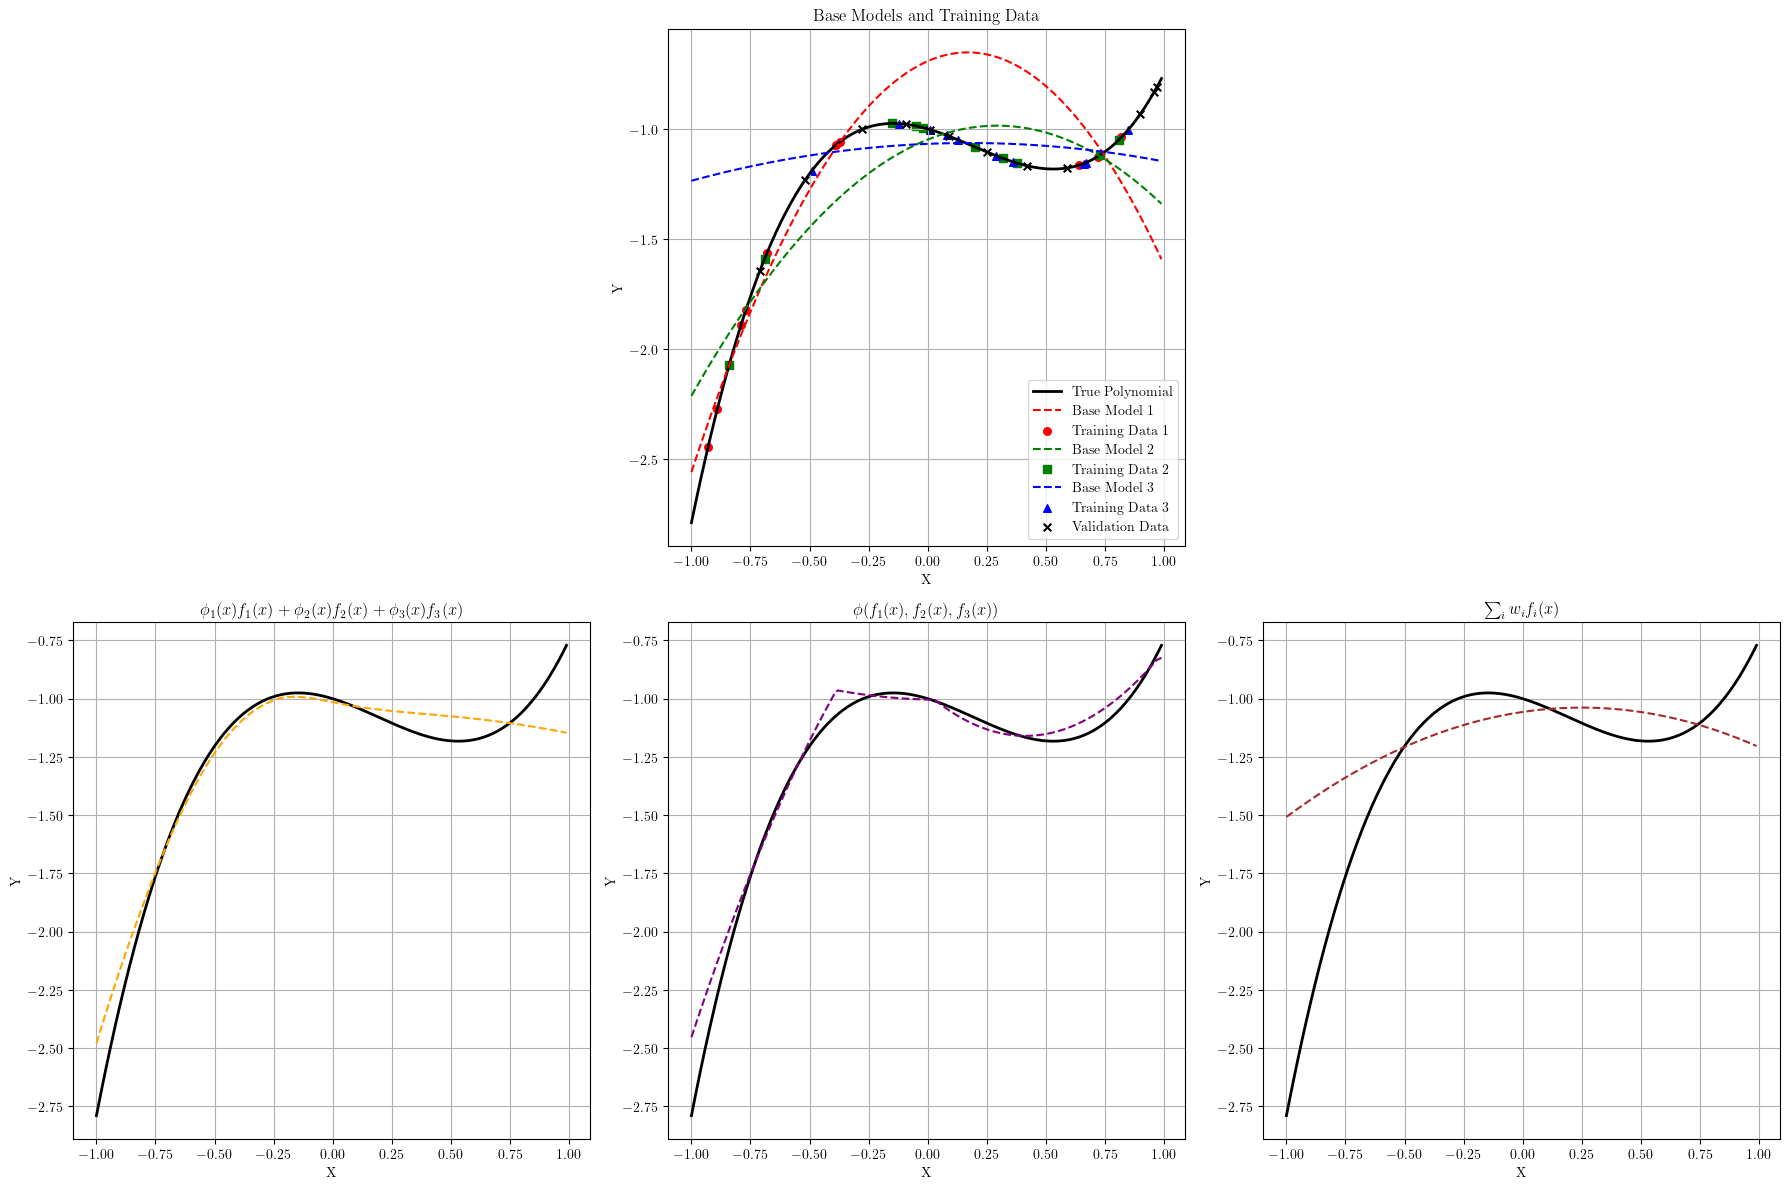

In [27]:
seed=12
np.random.seed(seed)
torch.manual_seed(10)
x = generate_points()
coefficients = [1.33, -0.77, -0.31, -1.00]
y, coefficients = generate_polynomial_values(x, degree=3, coefficients=coefficients)
x_train, y_train = sample_train_set(x, y)
bootstrap_models, indices_list = create_bootstraps_with_indices(x_train, y_train, degree=2)
np.random.seed(24)
x_val, y_val = sample_val_set(x, y, 12)

# Get predictions of the base models on the test and validation sets
ensemble = BaseModelEnsemble(bootstrap_models)
f_val = ensemble.predict(x_val)
f_test = ensemble.predict(x)

# The true y values at the validation points (y_true_val) should be computed using the true polynomial function
y_true_val = np.polyval(coefficients, x_val)

# Train the weighted ensemble network using validation data
weighted_ensemble_net, _ = train_weighted_ensemble_network(x_val, f_val, y_val)
# Predict on the test data using the trained weighted ensemble network
y_pred1 = predict_with_weighted_ensemble(weighted_ensemble_net, f_test, x)

# Train the direct ensemble network using validation data
direct_ensemble_net, _ = train_direct_ensemble_network(f_val, y_val)
# Predict on the test data using the trained direct ensemble network
y_pred2 = predict_with_direct_ensemble(direct_ensemble_net, f_test)

# Train the fixed weight ensemble network using validation data
fixed_weight_ensemble_net, _ = train_fixed_weight_ensemble(f_val, y_val)
# Predict on the test data using the trained fixed weight ensemble network
y_pred3, learned_weights = predict_with_fixed_weight_ensemble(fixed_weight_ensemble_net, f_test)


# Plotting the results
ensemble_predictions = [y_pred1, y_pred2, y_pred3]  # Replace y_pred2, y_pred3 with actual predictions if needed
labels = [
    r'$\phi_1(x) f_1(x) + \phi_2(x) f_2(x) + \phi_3(x) f_3(x)$',
    r'$\phi(f_1(x), f_2(x), f_3(x))$',
    r'$\sum_i w_i f_i(x)$'
]

# Plotting the results
plot_ensemble_results(x, y, [f_test[:, i] for i in range(3)], x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels)

In [40]:
def plot_ensemble_results_for_paper(x, y_true, base_models, x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels,
                                    linewidth=2,fontsize=12):
    """
    Plot the true polynomial, base models, training data, and ensemble predictions.
    Include markers to indicate which training points correspond to which base model.

    Parameters:
    - x (numpy.ndarray): The x values for the true polynomial and predictions.
    - y_true (numpy.ndarray): The y values of the true polynomial.
    - base_models (list): List of base model predictions.
    - x_train (numpy.ndarray): The x values for the training data.
    - y_train (numpy.ndarray): The y values for the training data.
    - indices_list (list): List of indices indicating which training points correspond to which base model.
    - x_val (numpy.ndarray): The x values for the validation data.
    - y_true_val (numpy.ndarray): True y values of the polynomial at validation points.
    - ensemble_predictions (list of numpy.ndarray): Predictions from the ensemble models.
    - labels (list of str): Labels for each ensemble prediction (e.g., ["y_pred1", "y_pred2", "y_pred3"]).
    """
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # First row: Plot only in the center figure
    # Hide the left and right plots in the first row
    #for ax in [axs[0, 0], axs[0, 2]]:
    #    ax.axis('off')

    # Center plot in the first row (True polynomial, base models, and training data)
    ax[0].plot(x, y_true, label='True Polynomial', color='black', linewidth=linewidth, zorder=-1)

    # Plot base models and training data
    colors = ['red', 'green', 'blue']
    markers = ['o', 's', '^']
    base_models_legends = ["$z_1(x)$", "$z_2(x)$", "$z_3(x)$"]

    for i, (f_model, (start_idx, end_idx)) in enumerate(zip(base_models, indices_list)):
        #ax_center.plot(x, f_model, label=f'Base Model {i+1}', color=colors[i], linestyle='--')
        ax[0].scatter(x_train[start_idx:end_idx], y_train[start_idx:end_idx], color=colors[i], label=f'Training Data {i+1}', s=20*linewidth, marker=markers[i],zorder=i+1)
    ax[0].tick_params(axis='both', labelsize=fontsize*0.8)
    ax[0].set_title('Training Data', fontsize=fontsize)
    ax[0].set_xlabel('$x$', fontsize=fontsize)
    ax[0].set_ylabel('$y$', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize*0.8)
    ax[0].grid(True)

    ax[1].plot(x, y_true, label='True Polynomial', color='black', linewidth=linewidth,zorder=-1)
    ax[1].scatter(x_val, y_true_val, color='brown', label='Validation Data', s=20*linewidth, marker='o',zorder=3)

    for i, (f_model, (start_idx, end_idx)) in enumerate(zip(base_models, indices_list)):
        ax[1].plot(x, f_model, label=base_models_legends[i], color=colors[i], linestyle='--', linewidth=linewidth,zorder=i)

    # Plot the validation data (same for all models)
    ax[1].tick_params(axis='both', labelsize=fontsize*0.8)
    ax[1].set_title('Validation Data and Base Models', fontsize=fontsize)
    ax[1].set_xlabel('$x$', fontsize=fontsize)
    #ax[1].set_ylabel('$y$', fontsize=fontsize)
    ax[1].legend(fontsize=fontsize*0.8)
    ax[1].grid(True)

    colors = ['orange', 'purple', 'brown']
    ax[2].plot(x, y_true, linewidth=linewidth, color='black',label='True Polynomial')

    # Second row: Show ensemble predictions
    for i in range(3):
        ax[2].plot(x, ensemble_predictions[i], linestyle='--', color=colors[i],  label=labels[i], linewidth=linewidth)
    ax[2].tick_params(axis='both', labelsize=fontsize*0.8)
    ax[2].set_title("Ensembler's Output", fontsize=fontsize)
    ax[2].set_xlabel('$x$', fontsize=fontsize)
   #ax[2].set_ylabel('$y$', fontsize=fontsize)
    ax[2].legend(fontsize=fontsize*0.8)
    ax[2].grid(True)
    
    plt.tight_layout()
    #plt.show()


### Performance Comparison of Ensemble Methods

The figure illustrates the performance comparison of three ensemble methods in approximating a true cubic polynomial function. The left panel shows the training data points used for each base model, marked with different symbols and colors. The middle panel displays the validation data along with the predictions of the base models, which are quadratic and hence do not perfectly fit the cubic function. The right panel compares the predictions of the three ensemble methods—Weighted Ensemble Network (which uses input-dependent weights), Direct Ensemble Network (which maps base predictions through a neural network), and Fixed Weight Ensemble Network (which uses constant weights)—against the true polynomial function. 



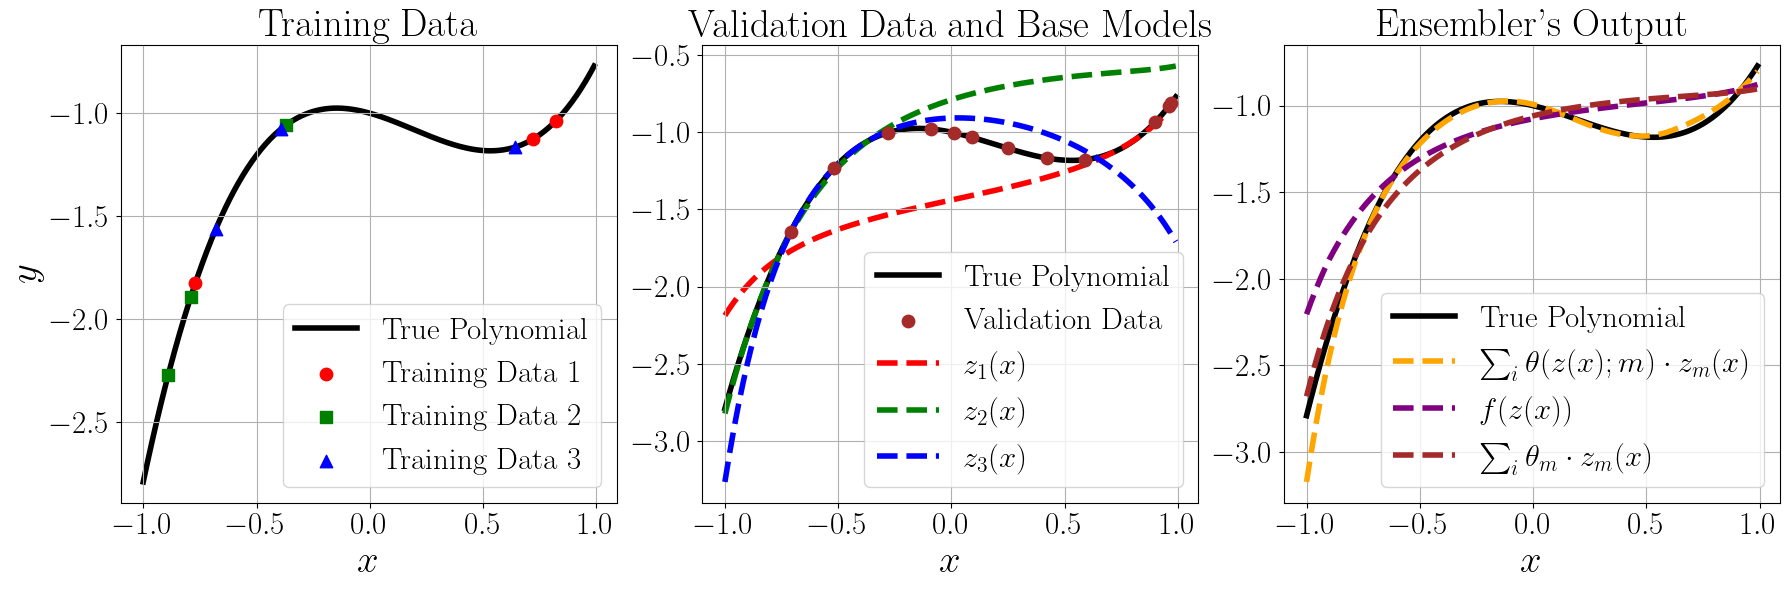

In [41]:
# Plotting the results
ensemble_predictions = [y_pred1, y_pred2, y_pred3]  # Replace y_pred2, y_pred3 with actual predictions if needed
labels = [
    r'$\sum_i \theta(z(x);m)\cdot z_m(x)$',
    r'$f(z(x))$',
    r'$\sum_i \theta_m \cdot z_m(x)$'
]
plot_ensemble_results_for_paper(x, y, [f_test[:, i] for i in range(3)], x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels,
                                linewidth=4, fontsize=28)
output_path = "/work/dlclarge2/janowski-quicktune/SearchingOptimalEnsembles/SearchingOptimalEnsembles_experiments/plots/figures"
filename = f"{output_path}/motivation_ensemble.pdf"
plt.savefig(filename, bbox_inches='tight')

In [42]:
for i in range(3):
    print(np.mean((ensemble_predictions[i] - y) ** 2))

0.004258849616324872
0.03579117272246979
0.019704574186179106


### Dynamic Ensemble Methods with Overparameterized Base Models
We investigate how dynamic ensemble methods perform when base models are overparameterized and trained on limited data, leading to overfitting. This addresses concerns about whether dynamic ensemblers only outperform baselines due to having more parameters or because base models underfit.

Coefficients are: [1.33, -0.77, -0.31, -1.0]


Early stopping at epoch 143 due to minimal loss change
Early stopping at epoch 170 due to minimal loss change
Early stopping at epoch 47 due to minimal loss change


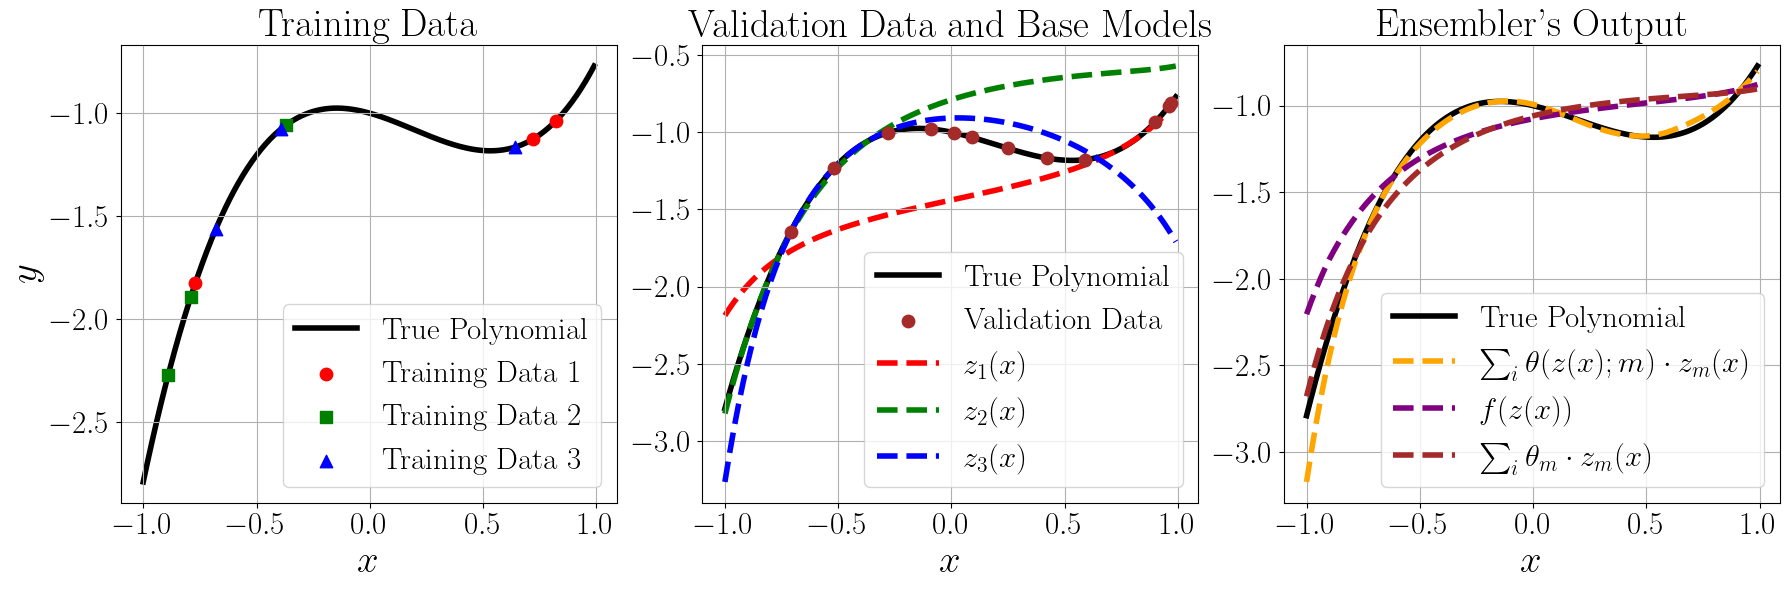

In [43]:
seed=12
np.random.seed(seed)
torch.manual_seed(10)
x = generate_points()
coefficients = [1.33, -0.77, -0.31, -1.00]
y, coefficients = generate_polynomial_values(x, degree=3, coefficients=coefficients)
x_train, y_train = sample_train_set(x, y, train_size=9)
bootstrap_models, indices_list = create_bootstraps_with_indices(x_train, y_train, degree=10)
np.random.seed(24)
x_val, y_val = sample_val_set(x, y, 12)

# Get predictions of the base models on the test and validation sets
ensemble = BaseModelEnsemble(bootstrap_models)
f_val = ensemble.predict(x_val)
f_test = ensemble.predict(x)

# The true y values at the validation points (y_true_val) should be computed using the true polynomial function
y_true_val = np.polyval(coefficients, x_val)

# Train the weighted ensemble network using validation data
weighted_ensemble_net, _ = train_weighted_ensemble_network(x_val, f_val, y_val)
# Predict on the test data using the trained weighted ensemble network
y_pred1 = predict_with_weighted_ensemble(weighted_ensemble_net, f_test, x)

# Train the direct ensemble network using validation data
direct_ensemble_net, _ = train_direct_ensemble_network(f_val, y_val)
# Predict on the test data using the trained direct ensemble network
y_pred2 = predict_with_direct_ensemble(direct_ensemble_net, f_test)

# Train the fixed weight ensemble network using validation data
fixed_weight_ensemble_net, _ = train_fixed_weight_ensemble(f_val, y_val)
# Predict on the test data using the trained fixed weight ensemble network
y_pred3, learned_weights = predict_with_fixed_weight_ensemble(fixed_weight_ensemble_net, f_test)

# Plotting the results
ensemble_predictions = [y_pred1, y_pred2, y_pred3]  # Replace y_pred2, y_pred3 with actual predictions if needed
labels = [
    r'$\sum_i \theta(z(x);m)\cdot z_m(x)$',
    r'$f(z(x))$',
    r'$\sum_i \theta_m \cdot z_m(x)$'
]
plot_ensemble_results_for_paper(x, y, [f_test[:, i] for i in range(3)], x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels,
                                linewidth=4, fontsize=28)
filename = f"{output_path}/motivation_ensemble_overparm_base_models.pdf"
plt.savefig(filename, bbox_inches='tight')

In [44]:
def ablation_study(
    network_type, x_val, f_val, y_val, f_test, x_test, y_true_test,
    n_layers_list, n_neurons_list, data_loss_threshold=1e-3, patience=10
):
    results = []
    for n_layers in n_layers_list:
        for n_neurons in n_neurons_list:
            print(f"Training {network_type} ensemble with {n_layers} layers and {n_neurons} neurons")
            if network_type == 'weighted':
                # Train the WeightedEnsembleNetwork
                ensemble_net, opt_info = train_weighted_ensemble_network(
                    x_val, f_val, y_val,
                    n_layers=n_layers,
                    n_neurons=n_neurons,
                    delta_loss_threshold=data_loss_threshold,
                    patience=patience
                )
                # Predict on the test data
                y_pred = predict_with_weighted_ensemble(ensemble_net, f_test, x_test)
            elif network_type == 'direct':
                # Train the DirectEnsembleNetwork
                ensemble_net, opt_info = train_direct_ensemble_network(
                    f_val, y_val,
                    n_layers=n_layers,
                    n_neurons=n_neurons,
                    delta_loss_threshold=data_loss_threshold,
                    patience=patience
                )
                # Predict on the test data
                y_pred = predict_with_direct_ensemble(ensemble_net, f_test)
            else:
                raise ValueError("Invalid network_type")

            # Compute MSE on the test data
            mse = np.mean((y_true_test - y_pred) ** 2)

            # Collect results
            result = {
                'network_type': network_type,
                'n_layers': n_layers,
                'n_neurons': n_neurons,
                'mse': mse,
                'total_time': opt_info['total_time'],
                'num_iterations': opt_info['num_iterations'],
                'avg_forward_time': opt_info['avg_forward_time'],
                'avg_backward_time': opt_info['avg_backward_time'],
                'y_pred': y_pred  # For plotting
            }
            results.append(result)
    return results

In [47]:
def plot_ablation_results(
    weighted_results, direct_results, n_layers_list, n_neurons_list, x, y_true,
    linewidth=4, fontsize=28, until_convergence=False
):
    num_rows = len(n_layers_list)
    num_cols = len(n_neurons_list)
    fig, axes = plt.subplots(
        nrows=num_rows, ncols=num_cols,
        figsize=(num_cols * 4, num_rows * 3),
        sharex=True, sharey=True
    )

    for i, n_layers in enumerate(n_layers_list):
        for j, n_neurons in enumerate(n_neurons_list):
            # Find the weighted result with matching n_layers and n_neurons
            res_weighted = next(
                (res for res in weighted_results
                 if res['n_layers'] == n_layers and res['n_neurons'] == n_neurons),
                None
            )
            # Find the direct result with matching n_layers and n_neurons
            res_direct = next(
                (res for res in direct_results
                 if res['n_layers'] == n_layers and res['n_neurons'] == n_neurons),
                None
            )
            ax = axes[i, j]

            # Plot the true polynomial
            ax.plot(x, y_true, color='black', linewidth=linewidth, label='True Polynomial')

            # Plot the weighted ensemble prediction
            if res_weighted is not None:
                y_pred_weighted = res_weighted['y_pred']
                mse_weighted = res_weighted['mse']
                ax.plot(x, y_pred_weighted, color='orange', linestyle='--', linewidth=linewidth, label=r'$\sum_i \theta(z(x);m)\cdot z_m(x)$')
            else:
                mse_weighted = None

            # Plot the direct ensemble prediction
            if res_direct is not None:
                y_pred_direct = res_direct['y_pred']
                mse_direct = res_direct['mse']
                ax.plot(x, y_pred_direct, color='purple', linestyle='--', linewidth=linewidth, label=r'$f(z(x))$')
            else:
                mse_direct = None

            # Set title and labels
            if i == 0:
                ax.set_title(f"Neurons: {n_neurons}", fontsize=fontsize)
            if j == 0:
                ax.set_ylabel(f"Layers: {n_layers}", fontsize=fontsize)

            # Add MSE annotations
            if mse_weighted is not None:
                ax.text(0.95, 0.15, f"MSE: {mse_weighted:.4f}", transform=ax.transAxes,
                        fontsize=fontsize*0.8, verticalalignment='bottom', horizontalalignment='right', color='orange')

            if mse_direct is not None:
                ax.text(0.95, 0.05, f"MSE: {mse_direct:.4f}", transform=ax.transAxes,
                        fontsize=fontsize*0.8, verticalalignment='bottom', horizontalalignment='right', color='purple')

            # Adjust tick parameters
            ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)

    # Create a single legend for the entire figure
    handles, labels = [], []
    for ax in fig.axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    # put the legend out of the plot, below it
    fig.legend(
        by_label.values(), by_label.keys(), 
        loc='lower center', 
        ncol=3, 
        fontsize=fontsize*0.6, 
        bbox_to_anchor=(0.5, -0.05)
    )

    plt.suptitle(f"Hyperparameter Ablation Study", fontsize=fontsize+4, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    # plt.show()
    
    name = "ablation_study" if not until_convergence else "ablation_study_convergence"
    filename = f"{output_path}/{name}.pdf"
    plt.savefig(filename, bbox_inches='tight')

### HP Ablation: Trained until Early Stopping

Training weighted ensemble with 1 layers and 8 neurons
Early stopping at epoch 26 due to minimal loss change
Training weighted ensemble with 1 layers and 16 neurons
Early stopping at epoch 22 due to minimal loss change
Training weighted ensemble with 1 layers and 32 neurons
Early stopping at epoch 21 due to minimal loss change
Training weighted ensemble with 1 layers and 64 neurons
Early stopping at epoch 20 due to minimal loss change
Training weighted ensemble with 2 layers and 8 neurons
Early stopping at epoch 34 due to minimal loss change
Training weighted ensemble with 2 layers and 16 neurons
Early stopping at epoch 32 due to minimal loss change
Training weighted ensemble with 2 layers and 32 neurons
Early stopping at epoch 22 due to minimal loss change
Training weighted ensemble with 2 layers and 64 neurons
Early stopping at epoch 17 due to minimal loss change
Training weighted ensemble with 3 layers and 8 neurons
Early stopping at epoch 12 due to minimal loss change
Training weig

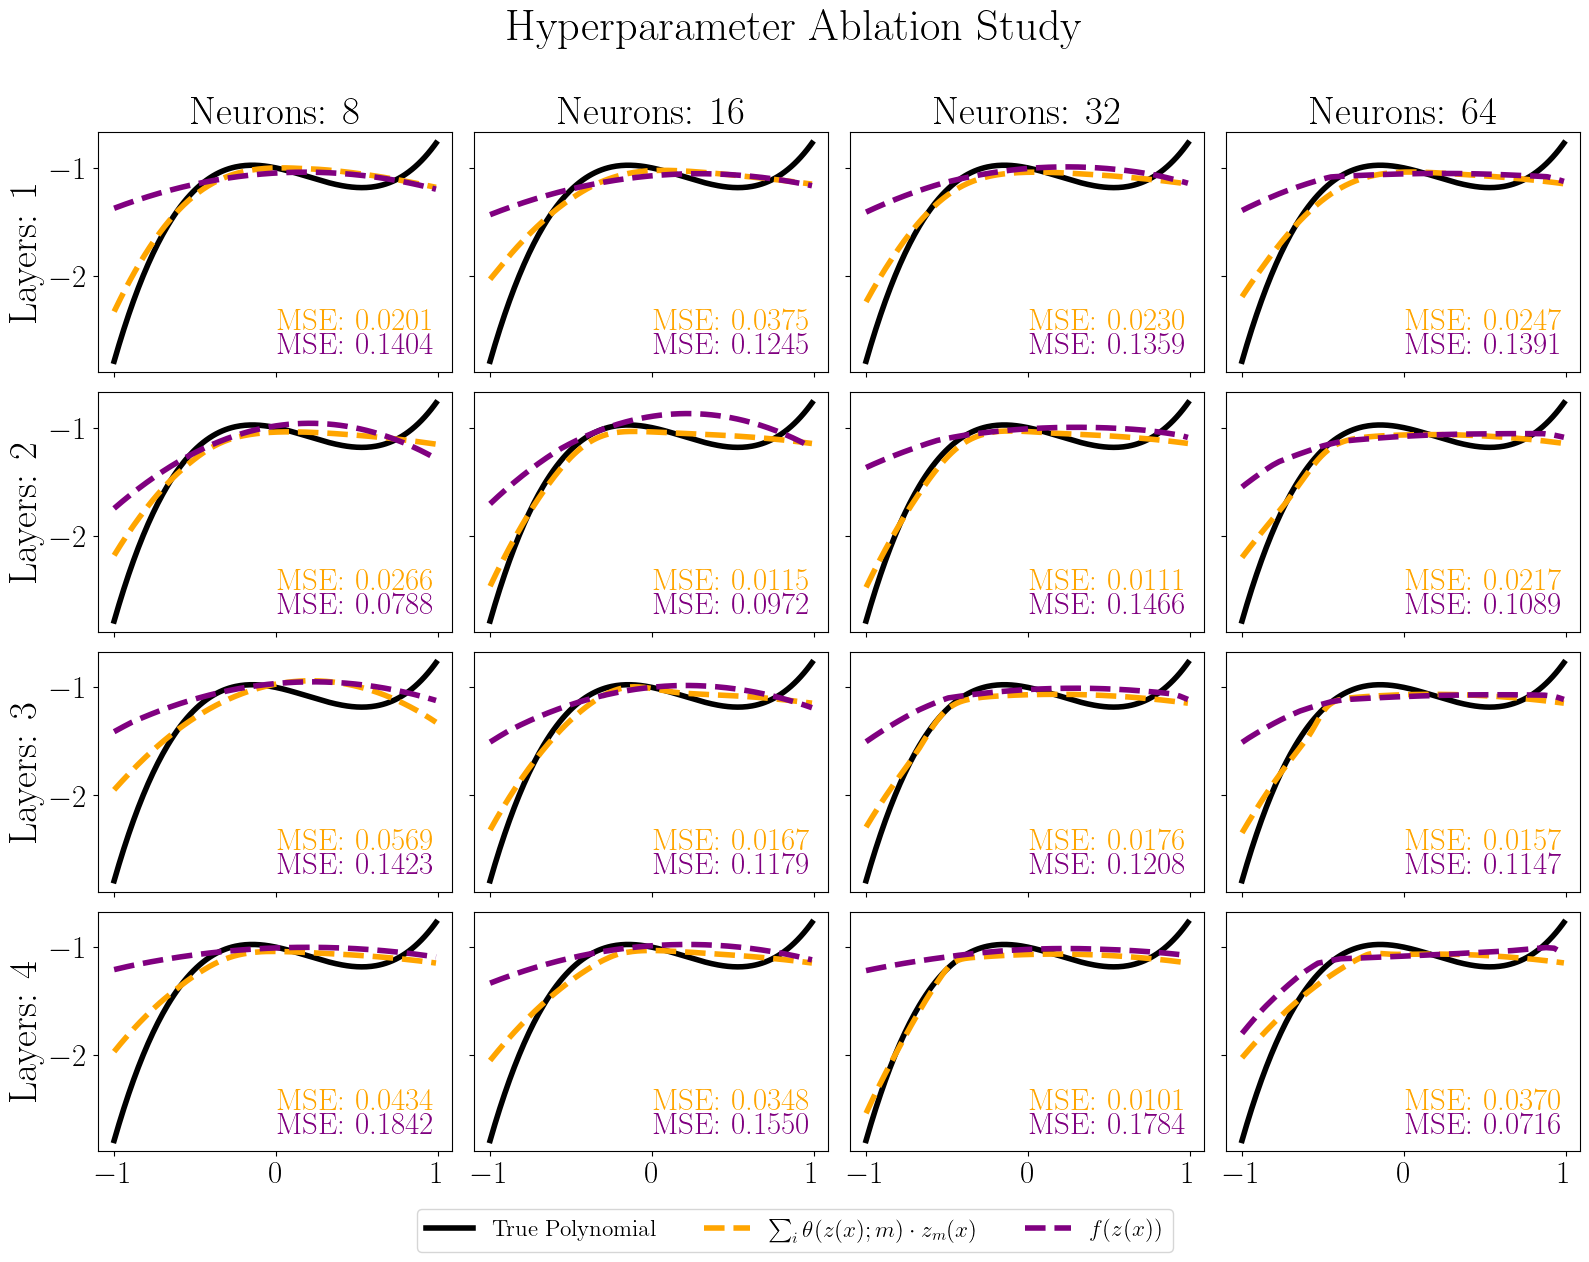

In [62]:
n_layers_list = [1, 2, 3, 4]
n_neurons_list = [8, 16, 32, 64]

# Run ablation study for WeightedEnsembleNetwork
weighted_results = ablation_study(
    'weighted', x_val, f_val, y_val, f_test, x, y, n_layers_list, n_neurons_list
)

# Run ablation study for DirectEnsembleNetwork
direct_results = ablation_study(
    'direct', x_val, f_val, y_val, f_test, x, y, n_layers_list, n_neurons_list
)

# Plotting results
plot_ablation_results(
    weighted_results, direct_results, n_layers_list, n_neurons_list,
    x, y, linewidth=4, fontsize=28
)


In [49]:
weighted_df = pd.DataFrame(weighted_results)
direct_df = pd.DataFrame(direct_results)

In [50]:
# print("Weighted Ensemble Network Results:")
# display(weighted_df[['n_layers', 'n_neurons', 'mse', 'total_time', 'num_iterations',
#                      'avg_forward_time', 'avg_backward_time']])

# print("\nDirect Ensemble Network Results:")
# display(direct_df[['n_layers', 'n_neurons', 'mse', 'total_time', 'num_iterations',
#                    'avg_forward_time', 'avg_backward_time']])

In [ ]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

heatmap_dict = {
    'weighted': r'$\sum_i \theta(z(x);m)\cdot z_m(x)$',
    'direct': r'$f(z(x))$'
}

def plot_metric_heatmap(weighted_df, direct_df, metric='mse', until_convergence=False):
    # Create pivot tables
    pivot_weighted = weighted_df.pivot(index='n_layers', columns='n_neurons', values=metric)
    pivot_direct = direct_df.pivot(index='n_layers', columns='n_neurons', values=metric)
    
    # Determine the combined min and max values for the color scale
    combined_min = min(pivot_weighted.min().min(), pivot_direct.min().min())
    combined_max = max(pivot_weighted.max().max(), pivot_direct.max().max())

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    # Increase font sizes
    fontsize_title = 28
    fontsize_subtitle = 24
    fontsize_labels = 24
    fontsize_ticks = 20
    fontsize_annot = 18

    # Plot for WeightedEnsembleNetwork
    sns.heatmap(pivot_weighted, annot=True, fmt=".4f", cmap='viridis', ax=axes[0],
                vmin=combined_min, vmax=combined_max, cbar=False,
                annot_kws={"fontsize": fontsize_annot})
    axes[0].set_title(f"{heatmap_dict['weighted']}", fontsize=fontsize_subtitle)
    axes[0].set_ylabel('Number of Layers', fontsize=fontsize_labels)
    axes[0].set_xlabel('Number of Neurons', fontsize=fontsize_labels)
    axes[0].tick_params(axis='both', which='major', labelsize=fontsize_ticks)

    # Plot for DirectEnsembleNetwork
    sns.heatmap(pivot_direct, annot=True, fmt=".4f", cmap='viridis', ax=axes[1],
                vmin=combined_min, vmax=combined_max, cbar=False,
                annot_kws={"fontsize": fontsize_annot})
    axes[1].set_title(f"{heatmap_dict['direct']}", fontsize=fontsize_subtitle)
    axes[1].set_ylabel('')  # No need to label Y-axis on the second plot
    axes[1].set_xlabel('Number of Neurons', fontsize=fontsize_labels)
    axes[1].tick_params(axis='both', which='major', labelsize=fontsize_ticks)

    # Add a main title
    fig.suptitle(f"{metric.upper()} Heatmap", fontsize=fontsize_title, y=0.98)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar and title

    # Add a single colorbar on the right
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

    # Create a normalizer and scalar mappable for the colorbar
    norm = Normalize(vmin=combined_min, vmax=combined_max)
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Dummy array for the scalar mappable

    # Add the colorbar to the figure
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=fontsize_ticks)
    # cbar.set_label(f"{metric.upper()}", fontsize=fontsize_labels)

    # Save the combined figure
    name = "heatmap" if not until_convergence else "heatmap_convergence"
    filename = f"{output_path}/combined_ensemble_{metric}_{name}.pdf"
    plt.savefig(filename, bbox_inches='tight')

    # Optionally display the plot
    # plt.show()

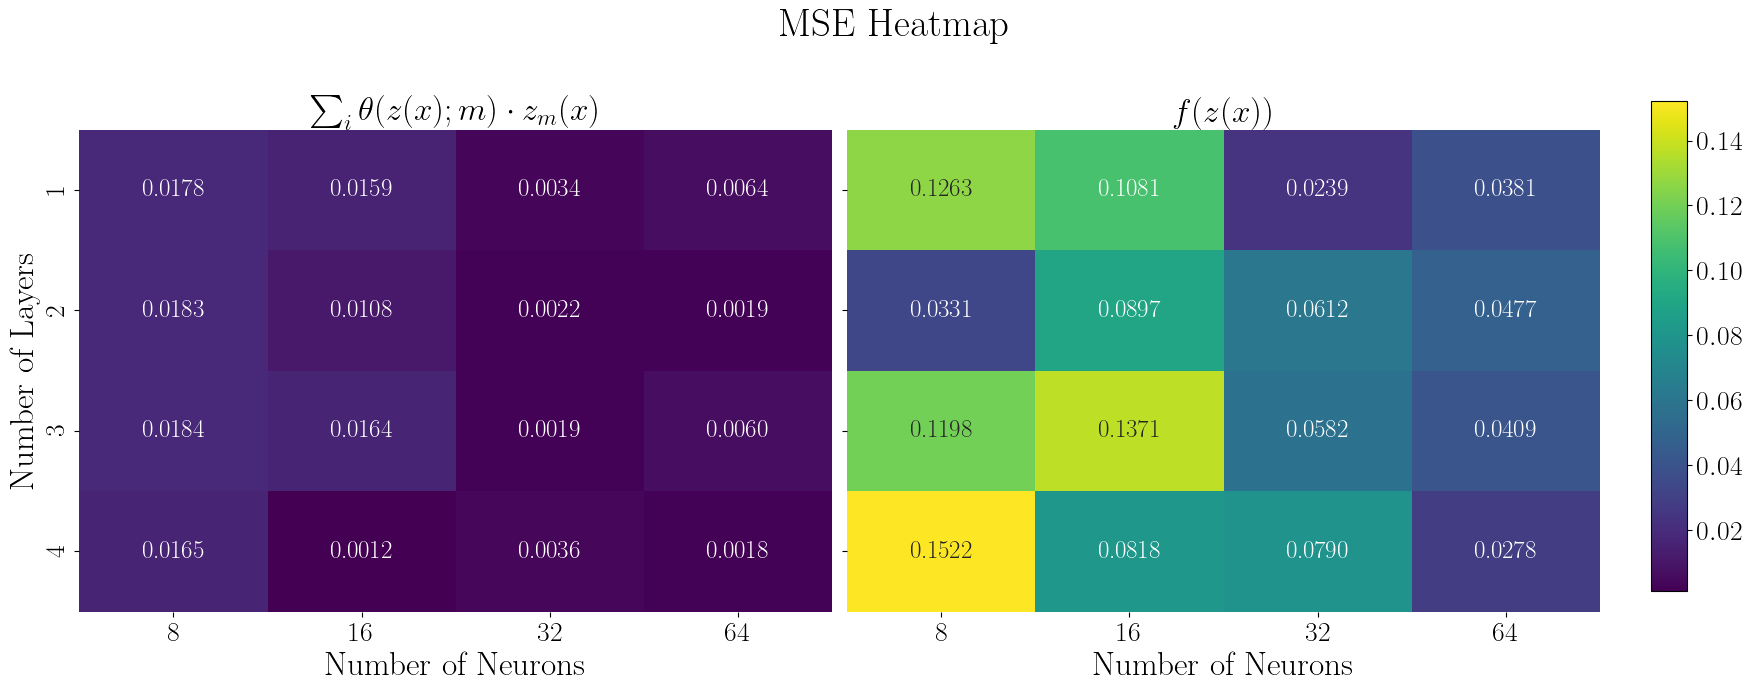

In [56]:
plot_metric_heatmap(weighted_df, direct_df, metric='mse', until_convergence=False)

### HP Ablation: Trained until Convergence

Training weighted ensemble with 1 layers and 8 neurons
Training weighted ensemble with 1 layers and 16 neurons
Early stopping at epoch 5992 due to minimal loss change
Training weighted ensemble with 1 layers and 32 neurons
Early stopping at epoch 5472 due to minimal loss change
Training weighted ensemble with 1 layers and 64 neurons
Early stopping at epoch 1530 due to minimal loss change
Training weighted ensemble with 2 layers and 8 neurons
Training weighted ensemble with 2 layers and 16 neurons
Early stopping at epoch 7913 due to minimal loss change
Training weighted ensemble with 2 layers and 32 neurons
Early stopping at epoch 4148 due to minimal loss change
Training weighted ensemble with 2 layers and 64 neurons
Early stopping at epoch 5766 due to minimal loss change
Training weighted ensemble with 3 layers and 8 neurons
Training weighted ensemble with 3 layers and 16 neurons
Training weighted ensemble with 3 layers and 32 neurons
Training weighted ensemble with 3 layers and 64 neu

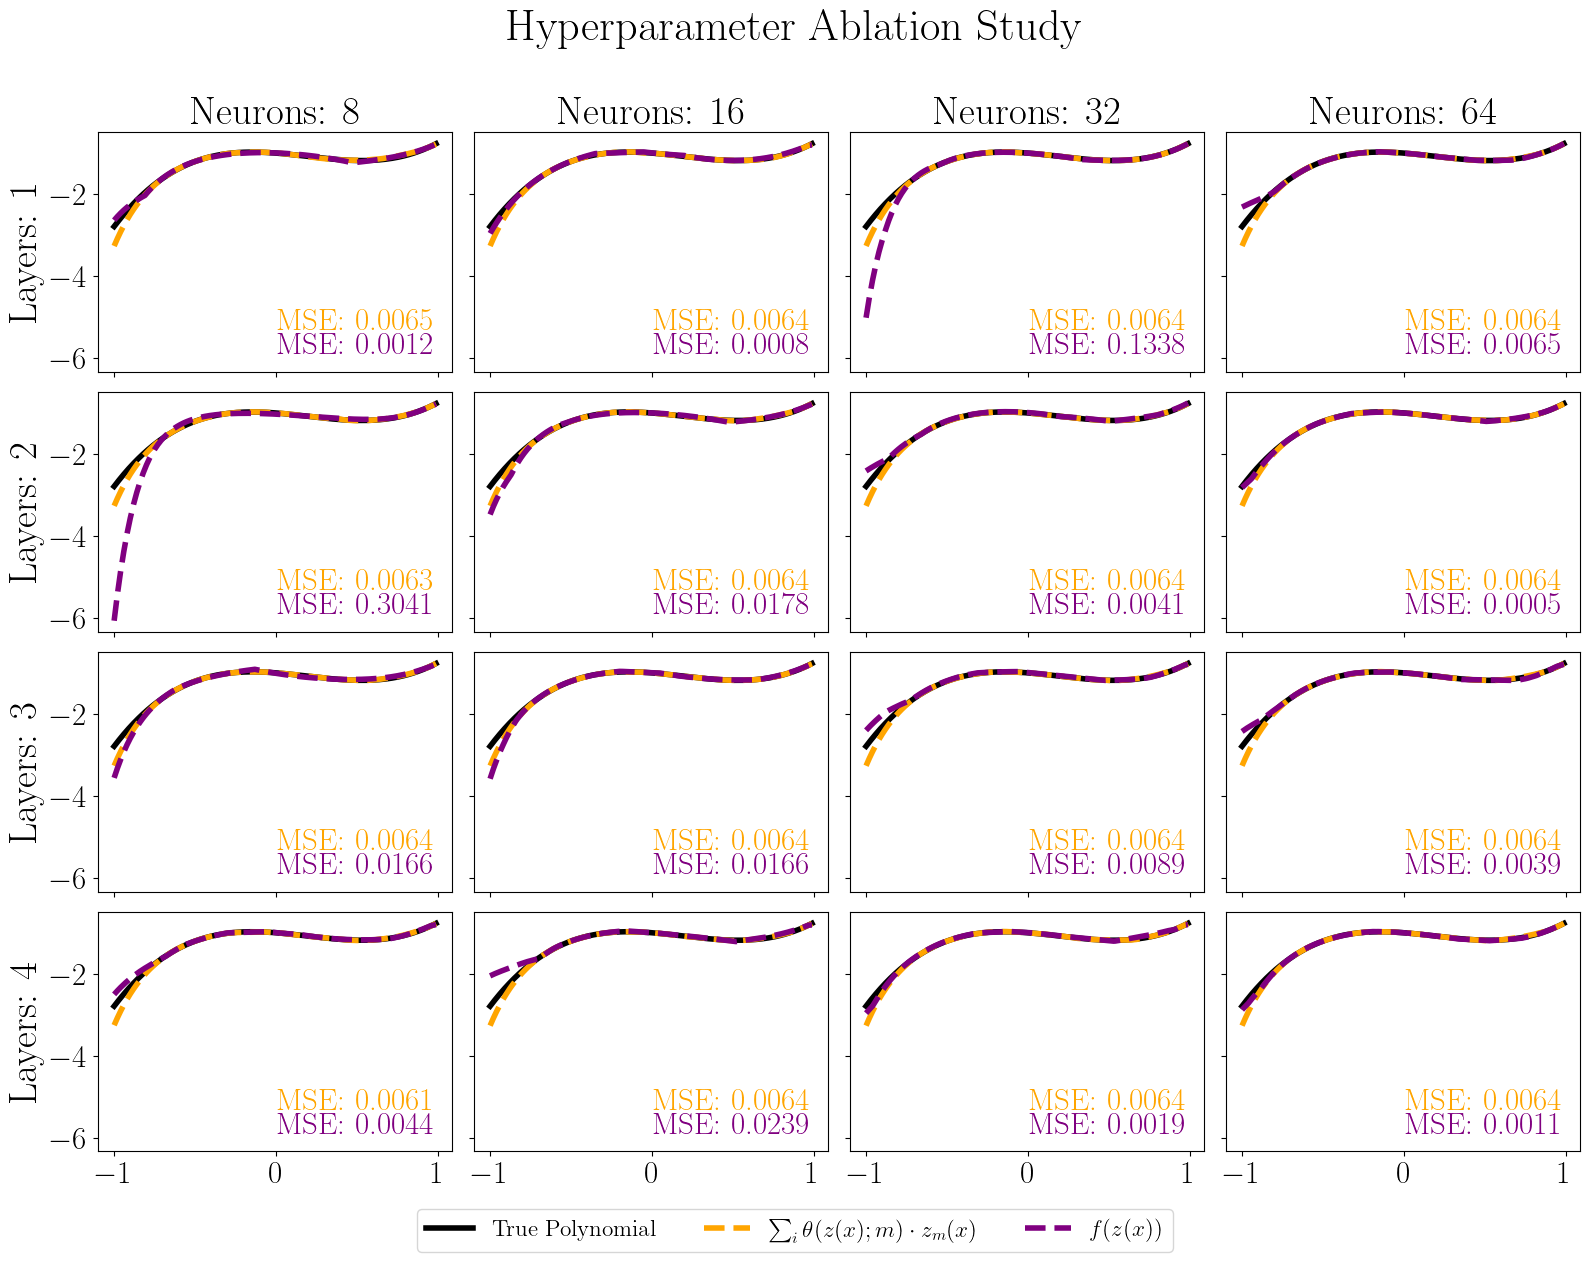

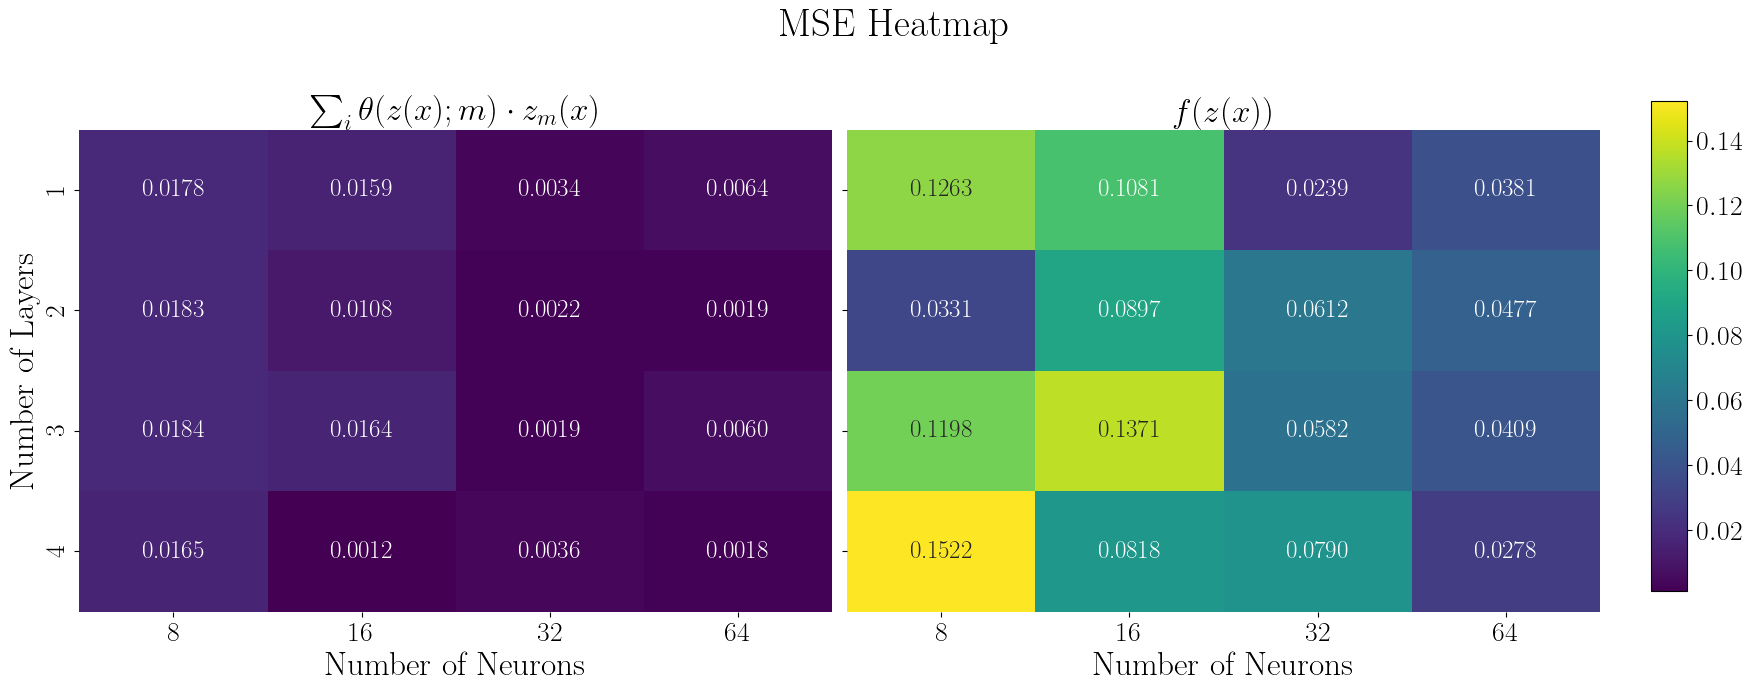

In [ ]:
n_layers_list = [1, 2, 3, 4]
n_neurons_list = [8, 16, 32, 64]

# Run ablation study for WeightedEnsembleNetwork
weighted_results = ablation_study(
    'weighted', x_val, f_val, y_val, f_test, x, y, n_layers_list, n_neurons_list, data_loss_threshold=1e-10
)

# Run ablation study for DirectEnsembleNetwork
direct_results = ablation_study(
    'direct', x_val, f_val, y_val, f_test, x, y, n_layers_list, n_neurons_list, data_loss_threshold=1e-10
)

# Plotting results
plot_ablation_results(
    weighted_results, direct_results, n_layers_list, n_neurons_list,
    x, y, linewidth=4, fontsize=28,  until_convergence=True
)

plot_metric_heatmap(weighted_df, direct_df, metric='mse', until_convergence=True)

### POC with Optimal HPs

Coefficients are: [1.33, -0.77, -0.31, -1.0]
Early stopping at epoch 151 due to minimal loss change
Early stopping at epoch 2135 due to minimal loss change
Early stopping at epoch 710 due to minimal loss change


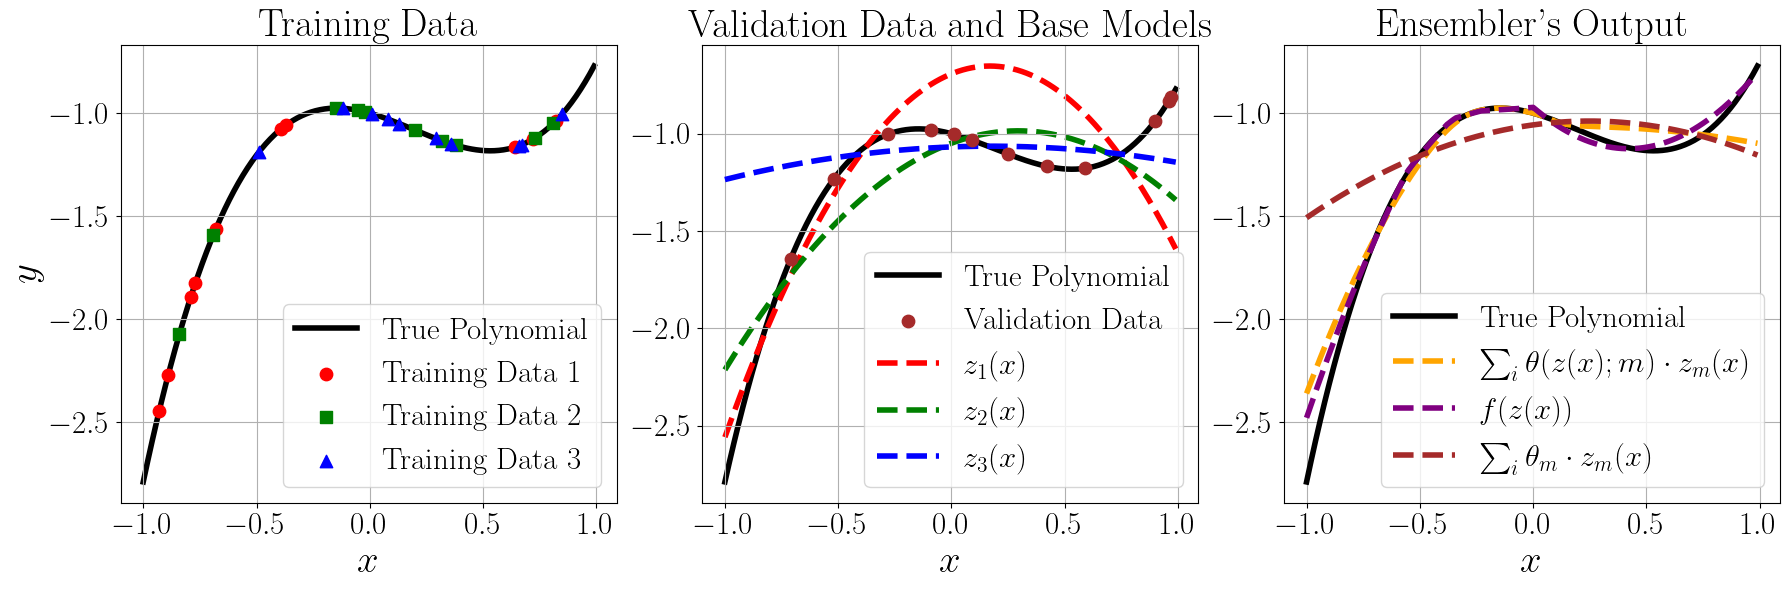

In [61]:
seed=12
np.random.seed(seed)
torch.manual_seed(10)
x = generate_points()
coefficients = [1.33, -0.77, -0.31, -1.00]
y, coefficients = generate_polynomial_values(x, degree=3, coefficients=coefficients)
x_train, y_train = sample_train_set(x, y)
bootstrap_models, indices_list = create_bootstraps_with_indices(x_train, y_train, degree=2)
np.random.seed(24)
x_val, y_val = sample_val_set(x, y, 12)

# Get predictions of the base models on the test and validation sets
ensemble = BaseModelEnsemble(bootstrap_models)
f_val = ensemble.predict(x_val)
f_test = ensemble.predict(x)

# The true y values at the validation points (y_true_val) should be computed using the true polynomial function
y_true_val = np.polyval(coefficients, x_val)

# Train the weighted ensemble network using validation data
weighted_ensemble_net, _ = train_weighted_ensemble_network(x_val, f_val, y_val, n_layers=4, n_neurons=16)
# Predict on the test data using the trained weighted ensemble network
y_pred1 = predict_with_weighted_ensemble(weighted_ensemble_net, f_test, x)

# Train the direct ensemble network using validation data
direct_ensemble_net, _ = train_direct_ensemble_network(f_val, y_val, n_layers=1, n_neurons=32)
# Predict on the test data using the trained direct ensemble network
y_pred2 = predict_with_direct_ensemble(direct_ensemble_net, f_test)

# Train the fixed weight ensemble network using validation data
fixed_weight_ensemble_net, _ = train_fixed_weight_ensemble(f_val, y_val)
# Predict on the test data using the trained fixed weight ensemble network
y_pred3, learned_weights = predict_with_fixed_weight_ensemble(fixed_weight_ensemble_net, f_test)

# Plotting the results
ensemble_predictions = [y_pred1, y_pred2, y_pred3]  # Replace y_pred2, y_pred3 with actual predictions if needed
labels = [
    r'$\sum_i \theta(z(x);m)\cdot z_m(x)$',
    r'$f(z(x))$',
    r'$\sum_i \theta_m \cdot z_m(x)$'
]
plot_ensemble_results_for_paper(x, y, [f_test[:, i] for i in range(3)], x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels,
                                linewidth=4, fontsize=28)
filename = f"{output_path}/motivation_ensemble_optimal_hps.pdf"
plt.savefig(filename, bbox_inches='tight')